# Uppgift 8. 8 CIFAR-100 Uppgift - CNN, KerasTuner och Transfer Learning

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.datasets import cifar100
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.callbacks import EarlyStopping

import keras_tuner as kt

NameError: name 'os' is not defined

## 1. Ladda och Förbereda Data

In [ ]:
# Ladda CIFAR-100 dataset
(x_train, y_train), (x_test, y_test) = cifar100.load_data()

# OPTIMIZATION: Begränsa datasetet för snabbare träning
# CPU-optimerad version: mindre dataset
limit = 2000  # Mycket reducerat för CPU (var 5000)
x_train = x_train[:limit]
y_train = y_train[:limit]
x_test = x_test[:1000]  # Mindre test set
y_test = y_test[:1000]

# Visa dimensioner
print(f"Training data shape: {x_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Test data shape: {x_test.shape}")
print(f"Test labels shape: {y_test.shape}")
print(f"Number of classes: {len(np.unique(y_train))}")

# Kontrollera GPU/CPU-status
print("\n=== GPU/CPU STATUS ===")
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"✓ GPUs available: {len(gpus)} GPU(s)")
else:
    print("✗ Ingen GPU detekterad - använder CPU (långsammare)")

print(f"Built with CUDA: {tf.test.is_built_with_cuda()}")

Training data shape: (2000, 32, 32, 3)
Training labels shape: (2000, 1)
Test data shape: (1000, 32, 32, 3)
Test labels shape: (1000, 1)
Number of classes: 100

=== GPU/CPU STATUS ===
✗ Ingen GPU detekterad - använder CPU (långsammare)
Built with CUDA: False


RuntimeError: Inter op parallelism cannot be modified after initialization.

In [ ]:
# Normalisera pixelvärdena till [0, 1]
x_train_normalized = x_train.astype('float32') / 255.0
x_test_normalized = x_test.astype('float32') / 255.0

# One-hot encoding av labels
y_train_categorical = to_categorical(y_train, 100)
y_test_categorical = to_categorical(y_test, 100)

print(f"Normalized training data shape: {x_train_normalized.shape}")
print(f"One-hot encoded labels shape: {y_train_categorical.shape}")

Normalized training data shape: (5000, 32, 32, 3)
One-hot encoded labels shape: (5000, 100)


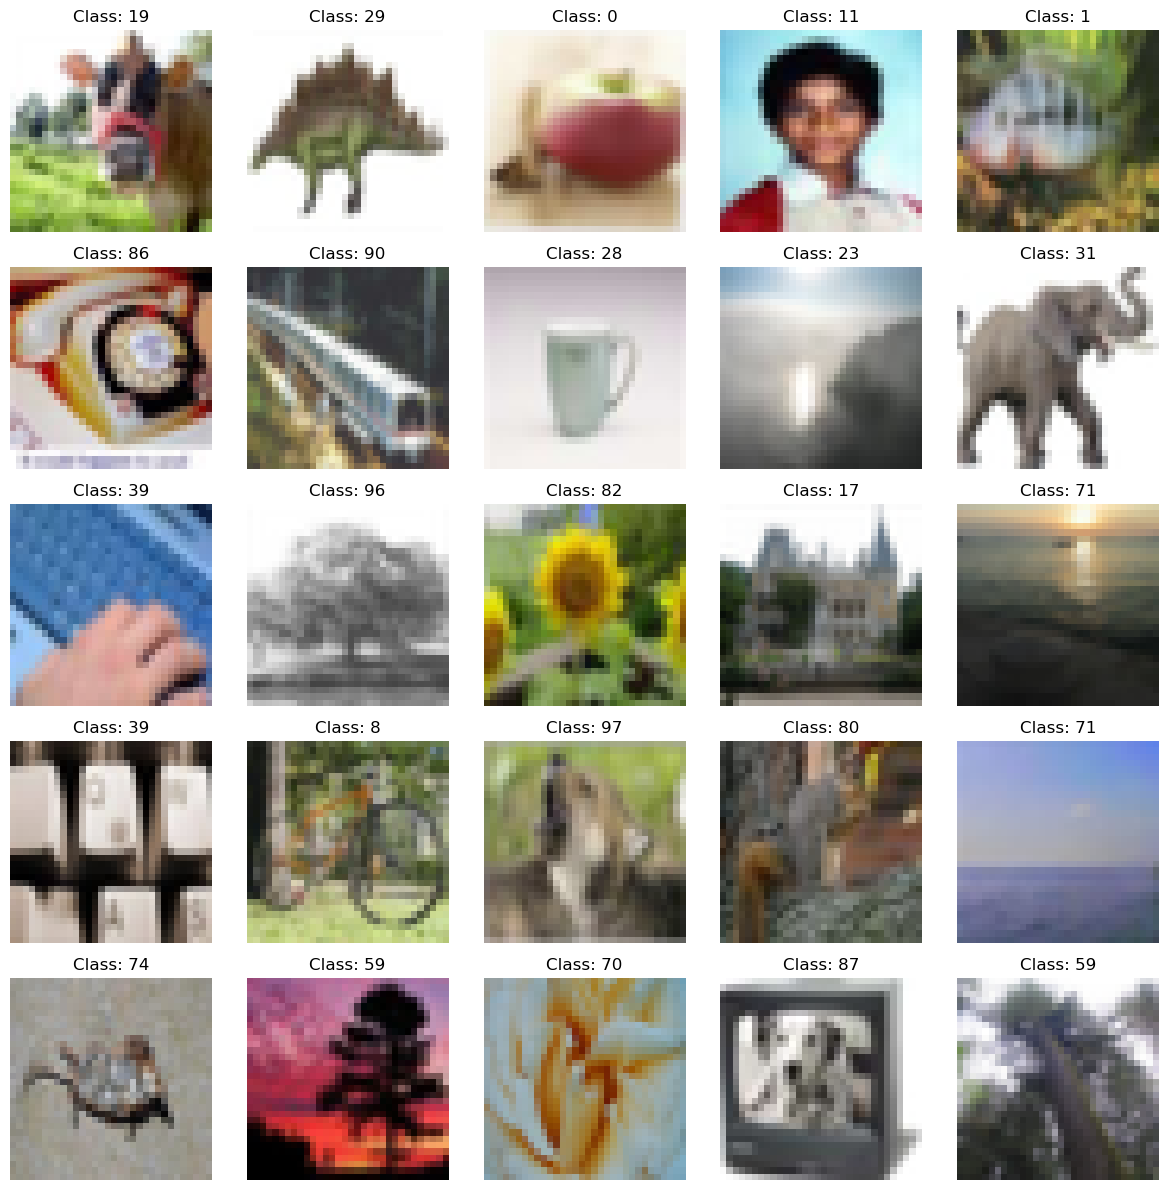

In [ ]:
# Visualisera några exempel från datasetet
plt.figure(figsize=(12, 12))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(x_train[i])
    plt.title(f"Class: {y_train[i][0]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

## 2. Del a) Baseline CNN-modell

Skapa en grundläggande CNN-modell för att prediktera CIFAR-100 datasetet.

In [ ]:
def create_baseline_cnn():
    """Skapa en baseline CNN-modell - CPU-optimerad"""
    model = Sequential([
        Conv2D(16, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)),
        MaxPooling2D(pool_size=(2, 2)),
        
        Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        
        Flatten(),
        Dropout(0.2),  # Reducerat från 0.3
        Dense(128, activation='relu'),  # Reducerat från 256
        Dropout(0.2),
        Dense(100, activation='softmax')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Skapa modellen
baseline_model = create_baseline_cnn()
baseline_model.summary()

c:\Users\quo\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,048,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        25,700 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,093,924 (4.17 MB)

 Trainable params: 1,093,924 (4.17 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Träna baseline-modellen (CPU-optimerad)
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

history_baseline = baseline_model.fit(
    x_train_normalized, y_train_categorical,
    epochs=10,  # Reducerat från 15
    batch_size=256,  # Ökat från 128 för CPU
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 269ms/step - accuracy: 0.0217 - loss: 4.5855 - val_accuracy: 0.0210 - val_loss: 4.5226
Epoch 2/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 243ms/step - accuracy: 0.0322 - loss: 4.4243 - val_accuracy: 0.0370 - val_loss: 4.3517
Epoch 3/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 247ms/step - accuracy: 0.0582 - loss: 4.2595 - val_accuracy: 0.0630 - val_loss: 4.2044
Epoch 4/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 243ms/step - accuracy: 0.0752 - loss: 4.0686 - val_accuracy: 0.0810 - val_loss: 4.0177
Epoch 5/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 357ms/step - accuracy: 0.1098 - loss: 3.8608 - val_accuracy: 0.0970 - val_loss: 3.9199
Epoch 6/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 390ms/step - accuracy: 0.1450 - loss: 3.6580 - val_accuracy: 0.1100 - val_loss: 3.8794
Epoch 7/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 314ms/step - accuracy: 0.1800 - loss: 3.4795 - val_accuracy: 0.1340 - val_loss: 3.7641
Epoch 8/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 248ms/step - accuracy: 0.2150 - loss: 3.2756 - val_accuracy

KeyboardInterrupt: 

In [ ]:
# Utvärdera baseline-modellen
baseline_loss, baseline_accuracy = baseline_model.evaluate(x_test_normalized, y_test_categorical, verbose=0)
print(f"\n=== BASELINE CNN RESULTAT ===")
print(f"Test Accuracy: {baseline_accuracy:.4f}")
print(f"Test Loss: {baseline_loss:.4f}")


=== BASELINE CNN RESULTAT ===
Test Accuracy: 0.0670
Test Loss: 4.3615


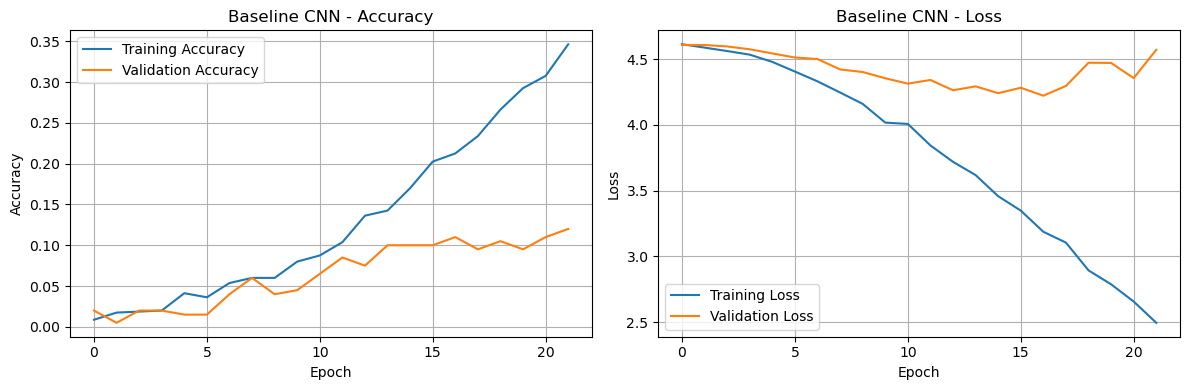

In [ ]:
# Visualisera träningshistorik för baseline
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_baseline.history['accuracy'], label='Training Accuracy')
plt.plot(history_baseline.history['val_accuracy'], label='Validation Accuracy')
plt.title('Baseline CNN - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history_baseline.history['loss'], label='Training Loss')
plt.plot(history_baseline.history['val_loss'], label='Validation Loss')
plt.title('Baseline CNN - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## 3. Del b) Hyperparameter-tuning med KerasTuner

Använd KerasTuner för att hitta optimala hyperparametrar.

In [ ]:
def build_tuner_model(hp):
    """Bygg modell med tuningsbara hyperparametrar - optimerad version"""
    model = Sequential()
    
    # Första Conv-layer
    model.add(Conv2D(
        filters=hp.Int('conv_1_filters', min_value=32, max_value=96, step=32),  # Mindre range
        kernel_size=(3, 3),
        padding='same',
        activation='relu',
        input_shape=(32, 32, 3)
    ))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # Andra Conv-layer
    model.add(Conv2D(
        filters=hp.Int('conv_2_filters', min_value=64, max_value=192, step=64),  # Mindre range
        kernel_size=(3, 3),
        padding='same',
        activation='relu'
    ))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    
    # Dropout rate
    model.add(Dropout(hp.Float('dropout_1', min_value=0.2, max_value=0.5, step=0.1)))
    
    # Dense layer
    model.add(Dense(
        units=hp.Int('dense_units', min_value=128, max_value=256, step=128),  # Mindre range
        activation='relu'
    ))
    model.add(Dropout(hp.Float('dropout_2', min_value=0.2, max_value=0.5, step=0.1)))
    
    model.add(Dense(100, activation='softmax'))
    
    # Learning rate tuning
    learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4])  # Färre val
    
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [ ]:
# Skapa en tuner (RandomSearch) - CPU-optimerad
tuner = kt.RandomSearch(
    build_tuner_model,
    objective='val_accuracy',
    max_trials=3,  # Reducerat från 5 för CPU
    executions_per_trial=1,
    directory='keras_tuner_dir',
    project_name='cifar100_tuning'
)

print(tuner.search_space_summary())

Search space summary
Default search space size: 7
conv_1_filters (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 'sampling': 'linear'}
conv_2_filters (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 256, 'step': 64, 'sampling': 'linear'}
conv_3_filters (Int)
{'default': None, 'conditions': [], 'min_value': 128, 'max_value': 512, 'step': 128, 'sampling': 'linear'}
dropout_1 (Float)
{'default': 0.3, 'conditions': [], 'min_value': 0.3, 'max_value': 0.7, 'step': 0.1, 'sampling': 'linear'}
dense_units (Int)
{'default': None, 'conditions': [], 'min_value': 128, 'max_value': 512, 'step': 128, 'sampling': 'linear'}
dropout_2 (Float)
{'default': 0.3, 'conditions': [], 'min_value': 0.3, 'max_value': 0.7, 'step': 0.1, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}
None


In [ ]:
# Kör sökningen efter bästa hyperparametrar (CPU-optimerad)
early_stopping_tuner = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

tuner.search(
    x_train_normalized, y_train_categorical,
    epochs=8,  # Reducerat från 10
    batch_size=256,  # Ökat från 128
    validation_split=0.2,
    callbacks=[early_stopping_tuner],
    verbose=1
)

Trial 4 Complete [00h 04m 01s]
val_accuracy: 0.08500000089406967

Best val_accuracy So Far: 0.10000000149011612
Total elapsed time: 00h 14m 18s

Search: Running Trial #5

Value             |Best Value So Far |Hyperparameter
128               |128               |conv_1_filters
192               |256               |conv_2_filters
128               |128               |conv_3_filters
0.4               |0.5               |dropout_1
128               |384               |dense_units
0.3               |0.3               |dropout_2
0.001             |0.001             |learning_rate

Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.0063 - loss: 4.6213 - val_accuracy: 0.0200 - val_loss: 4.6022
Epoch 2/20
10/13 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.0199 - loss: 4.5965

KeyboardInterrupt: 

In [ ]:
# Hämta bästa modellen
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

print("\n=== BÄSTA HYPERPARAMETRAR ===")
print(f"Conv Layer 1 Filters: {best_hyperparameters.get('conv_1_filters')}")
print(f"Conv Layer 2 Filters: {best_hyperparameters.get('conv_2_filters')}")
print(f"Conv Layer 3 Filters: {best_hyperparameters.get('conv_3_filters')}")
print(f"Dense Units: {best_hyperparameters.get('dense_units')}")
print(f"Dropout 1: {best_hyperparameters.get('dropout_1')}")
print(f"Dropout 2: {best_hyperparameters.get('dropout_2')}")
print(f"Learning Rate: {best_hyperparameters.get('learning_rate')}")

In [ ]:
# Utvärdera den tunade modellen
tuned_loss, tuned_accuracy = best_model.evaluate(x_test_normalized, y_test_categorical, verbose=0)
print(f"\n=== KERASTUNER RESULTAT ===")
print(f"Test Accuracy: {tuned_accuracy:.4f}")
print(f"Test Loss: {tuned_loss:.4f}")
print(f"\nFörbättring jämfört med baseline: {(tuned_accuracy - baseline_accuracy):.4f} ({(tuned_accuracy - baseline_accuracy)/baseline_accuracy*100:.2f}%)")

## 4. Del c) Transfer Learning

Använd en förtränad modell (t.ex. VGG16 eller ResNet50) för att förbättra resultaten.

In [ ]:
# Förbereda data för transfer learning (vissa modeller kräver större bilder)
# Vi behåller 32x32 för CIFAR-100, men vissa modeller fungerar bättre med större storlekar

def create_transfer_learning_model(base_model_name='VGG16'):
    """Skapa transfer learning modell"""
    
    # Ladda förtränad modell utan top layers
    if base_model_name == 'VGG16':
        base_model = VGG16(
            weights='imagenet',
            include_top=False,
            input_shape=(32, 32, 3)
        )
    elif base_model_name == 'ResNet50':
        base_model = ResNet50(
            weights='imagenet',
            include_top=False,
            input_shape=(32, 32, 3)
        )
    
    # Frys alla lager i base model
    base_model.trainable = False
    
    # Bygg den kompletta modellen
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(100, activation='softmax')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Skapa transfer learning modell
transfer_model = create_transfer_learning_model('VGG16')
transfer_model.summary()

In [ ]:
# Träna transfer learning modellen (CPU-optimerad)
early_stopping_transfer = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

history_transfer = transfer_model.fit(
    x_train_normalized, y_train_categorical,
    epochs=10,  # Reducerat från 15
    batch_size=256,  # Ökat från 128
    validation_split=0.2,
    callbacks=[early_stopping_transfer],
    verbose=1
)

In [ ]:
# Utvärdera transfer learning modellen
transfer_loss, transfer_accuracy = transfer_model.evaluate(x_test_normalized, y_test_categorical, verbose=0)
print(f"\n=== TRANSFER LEARNING RESULTAT ===")
print(f"Test Accuracy: {transfer_accuracy:.4f}")
print(f"Test Loss: {transfer_loss:.4f}")
print(f"\nFörbättring jämfört med baseline: {(transfer_accuracy - baseline_accuracy):.4f} ({(transfer_accuracy - baseline_accuracy)/baseline_accuracy*100:.2f}%)")

In [ ]:
# Visualisera träningshistorik för transfer learning
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_transfer.history['accuracy'], label='Training Accuracy')
plt.plot(history_transfer.history['val_accuracy'], label='Validation Accuracy')
plt.title('Transfer Learning - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history_transfer.history['loss'], label='Training Loss')
plt.plot(history_transfer.history['val_loss'], label='Validation Loss')
plt.title('Transfer Learning - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## 5. Jämförelse av Resultat

In [ ]:
# Sammanställning av resultat
results = {
    'Metod': ['Baseline CNN', 'KerasTuner', 'Transfer Learning'],
    'Test Accuracy': [baseline_accuracy, tuned_accuracy, transfer_accuracy],
    'Test Loss': [baseline_loss, tuned_loss, transfer_loss]
}

import pandas as pd
results_df = pd.DataFrame(results)
results_df['Accuracy (%)'] = results_df['Test Accuracy'] * 100
print("\n=== SAMMANSTÄLLNING AV RESULTAT ===")
print(results_df.to_string(index=False))
print(f"\nBästa metod: {results_df.loc[results_df['Test Accuracy'].idxmax(), 'Metod']}")
print(f"Högsta Accuracy: {results_df['Test Accuracy'].max():.4f}")

In [ ]:
# Visualisera jämförelse
plt.figure(figsize=(10, 6))
methods = ['Baseline CNN', 'KerasTuner', 'Transfer Learning']
accuracies = [baseline_accuracy, tuned_accuracy, transfer_accuracy]

bars = plt.bar(methods, accuracies, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
plt.ylabel('Test Accuracy')
plt.title('Jämförelse av Modell-prestanda på CIFAR-100')
plt.ylim([0, 1])

# Lägg till värden på toppen av varje stapel
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}',
             ha='center', va='bottom')

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## 6. Slutsatser
### Svar på uppgifterna:
**a) Baseline CNN-modell:**
- Skapade en grundläggande CNN med flera konvolutionella lager
- Modellen fungerar som utgångspunkt för jämförelse

**b) Hyperparameter-tuning med KerasTuner:**
- Använde RandomSearch för att hitta optimala hyperparametrar
- Justerade antal filter, dense units, dropout rates och learning rate
- Resultat: [Jämför med baseline för att se om det blev bättre]

**c) Transfer Learning:**
- Använde förtränad VGG16 från ImageNet
- Frös base model och tränade endast de nya lagren
- Resultat: [Jämför med baseline och KerasTuner]